In [1]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import tqdm
%matplotlib inline
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from IPython.display import HTML
from base64 import b64encode
from tensorflow.keras.layers import Input,Dense, Flatten, ReLU, Conv2D, DepthwiseConv2D,AvgPool2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from typing import Optional
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')



/tmp/ipykernel_30/1542781770.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
def Play_Video(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [3]:
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 30

In [4]:
CLASSES_LIST = ["E05(Circumduction)"]

In [5]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [6]:
def create_dataset(video_dir, csv_file_path):
    features = []
    labels = []
    video_files_paths = []
    matching_files_count = 0

    # Read the CSV file
    csv_data = pd.read_csv(csv_file_path)

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(video_dir, class_name))

        for file_name in files_list:
            # Remove the .mp4 extension from the file name
            video_name = os.path.splitext(file_name)[0]

            video_file_path = os.path.join(video_dir, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                # Search for the exercise name in the CSV data that matches with video file name
                matching_row = csv_data[csv_data['Excercise Name'].str.lower() == video_name.lower()]

                if not matching_row.empty:
                    assessment_score = matching_row['Assessment Score'].values[0]
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
                    matching_files_count += 1
                    print(f'Matched file: {video_name}, Assessment Score: {assessment_score}')
                else:
                    # Append None if no matching row is found
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
                    print(f'No matching row found for file: {video_name}')

    features = np.asarray(features)
    labels = np.asarray(labels)

    print(f'Total matching files: {matching_files_count}')

    return features, labels, matching_files_count, video_files_paths


In [7]:
import pandas as pd

video_dir = '/kaggle/input/regression-folders/dataset_regression'
csv_file_path = '/kaggle/input/csv-files-regression/Ex_05_sub.csv'
features, labels, matching_files_count, video_files_paths =  create_dataset(video_dir, csv_file_path)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print("Matching files count:", matching_files_count)
print("Number of video files:", len(video_files_paths))

Extracting Data of Class: E05(Circumduction)
Matched file: E05_P36_AL_VFL_GM, Assessment Score: 53.81
Matched file: E05_P32_AR_VFL_GM, Assessment Score: 19.05
Matched file: E05_P29_AL_VFL_GM, Assessment Score: 33.33
Matched file: E05_P31_AF_VML_GM, Assessment Score: 67.14
Matched file: E05_P21_AF_VLL_GM, Assessment Score: 62.38
Matched file: E05_P02_AF_VHJ_GM, Assessment Score: 70.48
Matched file: E05_P12_AL_VML_GF, Assessment Score: 82.86
Matched file: E05_P13_AR_VML_GF, Assessment Score: 78.1
Matched file: E05_P01_AR_VFL_GM, Assessment Score: 75.71
Matched file: E05_P31_AF_VLR_GM, Assessment Score: 67.14
Matched file: E05_P01_AF_VHJ_GM, Assessment Score: 84.29
Matched file: E05_P22_AF_VHJ_GM, Assessment Score: 76.67
Matched file: E05_P07_AR_VHJ_GM, Assessment Score: 60.0
Matched file: E05_P34_AF_VHJ_GF, Assessment Score: 16.67
Matched file: E05_P36_AF_VML_GM, Assessment Score: 50.0
Matched file: E05_P01_AF_VFL_GM, Assessment Score: 78.57
Matched file: E05_P22_AR_VLJ_GM, Assessment Sc

In [8]:
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

In [9]:
features, labels, video_files_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

In [10]:
print(f'Number of features: {len(features)}, Number of labels: {len(labels)}, Number of video_files_paths: {len(video_files_paths)}')

Number of features: 80, Number of labels: 80, Number of video_files_paths: 80


In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.20, shuffle=True, random_state=42
)

print(f"Training features: {features_train.shape}, Training labels: {labels_train.shape}")
print(f"Testing features: {features_test.shape}, Testing labels: {labels_test.shape}")


Training features: (64, 30, 128, 128, 3), Training labels: (64,)
Testing features: (16, 30, 128, 128, 3), Testing labels: (16,)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np

# Define RMSE and MAD as custom metrics with correct casting
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def mad(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    return tf.reduce_mean(tf.abs(y_pred - tf.reduce_mean(y_pred)))



# Define the CNN + LSTM model
def create_cnn_lstm_model(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH):
    """
    A CNN + LSTM model for sequence prediction.
    """
    # Define the video input (3D input for CNN + LSTM)
    video_input = layers.Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    
    # CNN layers for feature extraction
    x = layers.Conv3D(32, (3, 3, 3), padding='same', activation='relu')(video_input)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(64, (3, 3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    # Flatten the output of the CNN to make it compatible with LSTM
    x = layers.Reshape((-1, x.shape[1] * x.shape[2] * x.shape[3]))(x)  # Flatten the spatial dimensions

    # LSTM layer to capture temporal dependencies
    x = layers.LSTM(64, return_sequences=False)(x)
    
    # Dense layer with sigmoid activation to scale output to [0, 1]
    regression_output = layers.Dense(1, activation='sigmoid', name='regression_output')(x)
    
    # Build the model
    model = models.Model(inputs=video_input, outputs=[regression_output])
    model.summary()
    
    return model


In [13]:
# Define hyperparameters
SEQUENCE_LENGTH = 30  # Set according to your input data
IMAGE_HEIGHT = 128  # Set the height of your input images
IMAGE_WIDTH = 128  # Set the width of your input images

# Create the model
model = create_cnn_lstm_model(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 30, 128, 128,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 64, 64, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 7, 32, 32, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 32, 32, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 32, 32, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 7168)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     1,851,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ regression_output (Dense)       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,910,081 (7.29 MB)

 Trainable params: 1,909,889 (7.29 MB)

 Non-trainable params: 192 (768.00 B)

In [14]:
# Compile the model for regression task
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='mean_squared_error',  # Use MSE for regression
              metrics=['mean_absolute_error', rmse, mad])

# Define Early Stopping and Learning Rate Scheduler callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * 0.5 if epoch % 5 == 0 and epoch > 0 else lr, verbose=1)

callbacks = [early_stopping, lr_scheduler]

# Train the model
history = model.fit(features_train, labels_train,
                    validation_data=(features_test, labels_test),
                    epochs=60, batch_size=8, verbose=1, 
                    callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 154s 18s/step - loss: 0.1803 - mad: 0.0767 - mean_absolute_error: 0.3976 - rmse: 0.4124 - val_loss: 0.2894 - val_mad: 0.0314 - val_mean_absolute_error: 0.5362 - val_rmse: 0.5378 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 144s 18s/step - loss: 0.0257 - mad: 0.0616 - mean_absolute_error: 0.1270 - rmse: 0.1479 - val_loss: 0.1708 - val_mad: 0.0409 - val_mean_absolute_error: 0.4096 - val_rmse: 0.4130 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 139s 17s/step - loss: 0.0022 - mad: 0.0196 - mean_absolute_error: 0.0372 - rmse: 0.0455 - val_loss: 0.0831 - val_mad: 0.0387 - val_mean_absolute_error: 0.2838 - val_rmse: 0.2881 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler se

In [15]:
# Evaluate the model on the test data
evaluation = model.evaluate(features_test, labels_test)

# Print the evaluation results with four decimal places
print(f"Evaluation Loss (MSE): {evaluation[0]:.5f}")
print(f"Evaluation MAE: {evaluation[1]:.5f}")
print(f"Evaluation RMSE: {evaluation[2]:.5f}")
print(f"Evaluation MAD: {evaluation[3]:.5f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 8.5573e-05 - mad: 0.0016 - mean_absolute_error: 0.0090 - rmse: 0.0093
Evaluation Loss (MSE): 0.00009
Evaluation MAE: 0.00900
Evaluation RMSE: 0.00925
Evaluation MAD: 0.00163


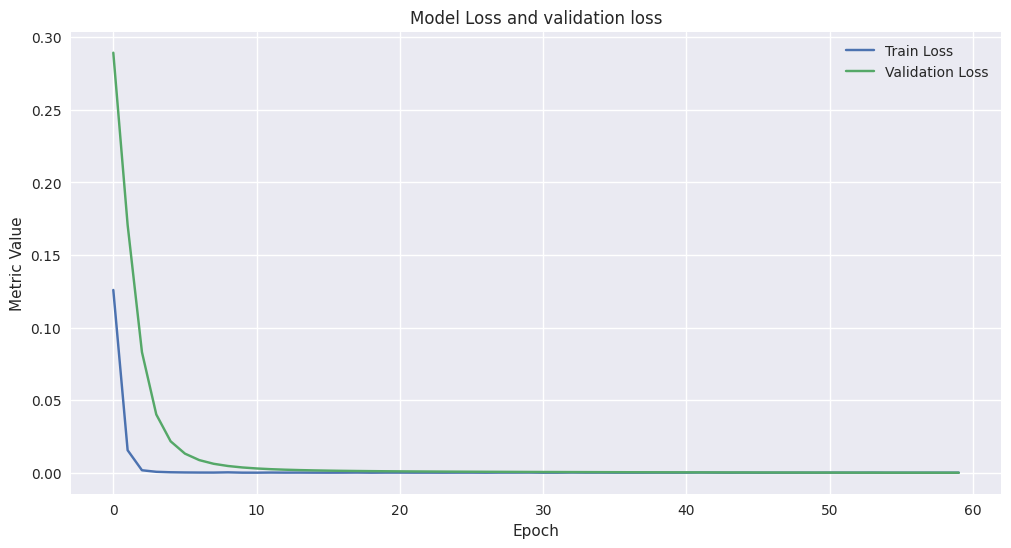

In [16]:
# Plot the Train loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

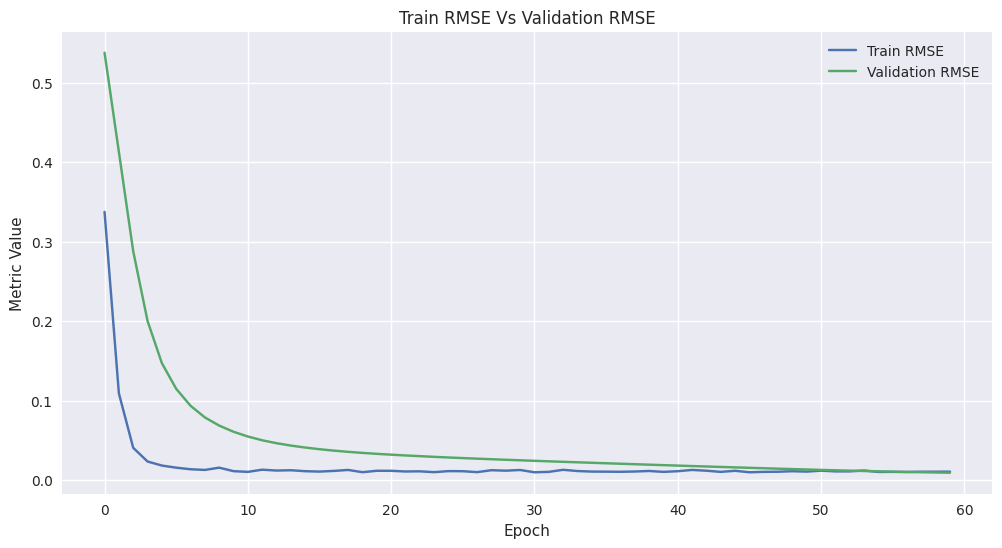

In [17]:
# Plot the train rmse and validation rmse
plt.figure(figsize=(12, 6))
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.title('Train RMSE Vs Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()


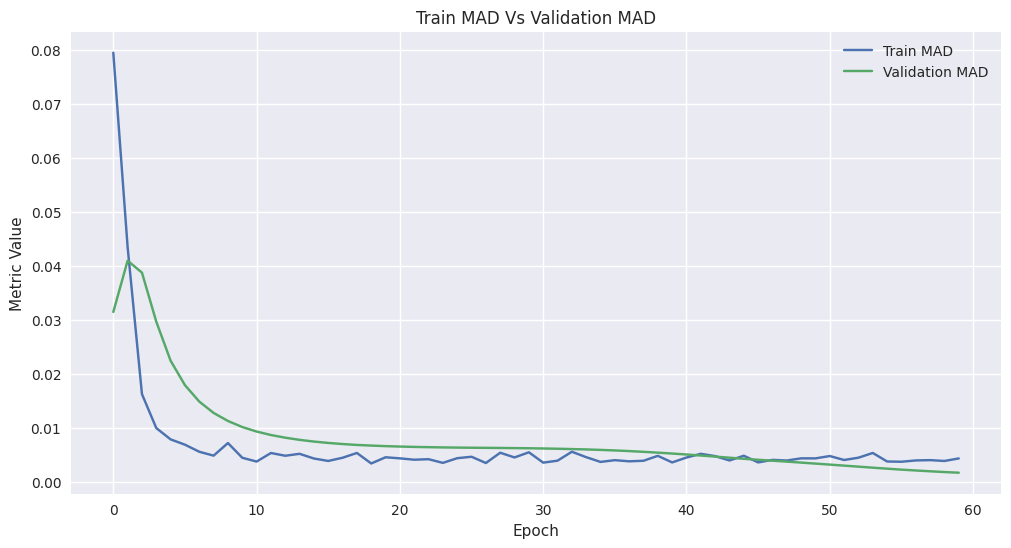

In [18]:
# Plot the tain MAD and validation MAD
plt.figure(figsize=(12, 6))
plt.plot(history.history['mad'], label='Train MAD')
plt.plot(history.history['val_mad'], label='Validation MAD')
plt.title('Train MAD Vs Validation MAD')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()



In [19]:
model.save('Conv3d(E05).h5')

In [20]:
import os
import cv2
import numpy as np

# Function to save all split videos from the test set to a folder
def save_all_split_videos(video_data, save_dir, SEQUENCE_LENGTH=16, IMAGE_HEIGHT=64, IMAGE_WIDTH=64, fps=30):
    """
    Save all split videos from the video data as individual video files in the specified directory.

    Args:
        video_data: Numpy array containing video data of shape (num_videos, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3).
        save_dir: Directory to save the videos.
        SEQUENCE_LENGTH: Number of frames per video (default is 16).
        IMAGE_HEIGHT: Height of the frames (default is 64).
        IMAGE_WIDTH: Width of the frames (default is 64).
        fps: Frames per second for the output videos (default is 30).
    """
    # Create the save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Iterate over all videos in the dataset
    for video_index in range(video_data.shape[0]):
        video_frames = video_data[video_index]  # Shape: (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

        # Prepare the VideoWriter object to save the video
        video_filename = os.path.join(save_dir, f"split_video_{video_index + 1}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' for .mp4 format
        video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (IMAGE_WIDTH, IMAGE_HEIGHT))

        # Add frames to the video
        for frame in video_frames:
            # Ensure the frame has values in the range [0, 255] and convert to uint8
            frame_rgb = (frame * 255).astype(np.uint8)
            # Convert RGB to BGR for OpenCV
            frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
            # Write the frame to the video
            video_writer.write(frame_bgr)

        # Release the video writer
        video_writer.release()
        print(f"Video {video_index + 1} saved to: {video_filename}")

# Example usage: Save all split videos from the test set
# Make sure `features_test` is defined before calling this function
save_all_split_videos(features_test, save_dir="/kaggle/working/split_videos")


Video 1 saved to: /kaggle/working/split_videos/split_video_1.mp4
Video 2 saved to: /kaggle/working/split_videos/split_video_2.mp4
Video 3 saved to: /kaggle/working/split_videos/split_video_3.mp4
Video 4 saved to: /kaggle/working/split_videos/split_video_4.mp4
Video 5 saved to: /kaggle/working/split_videos/split_video_5.mp4
Video 6 saved to: /kaggle/working/split_videos/split_video_6.mp4
Video 7 saved to: /kaggle/working/split_videos/split_video_7.mp4
Video 8 saved to: /kaggle/working/split_videos/split_video_8.mp4
Video 9 saved to: /kaggle/working/split_videos/split_video_9.mp4
Video 10 saved to: /kaggle/working/split_videos/split_video_10.mp4
Video 11 saved to: /kaggle/working/split_videos/split_video_11.mp4
Video 12 saved to: /kaggle/working/split_videos/split_video_12.mp4
Video 13 saved to: /kaggle/working/split_videos/split_video_13.mp4
Video 14 saved to: /kaggle/working/split_videos/split_video_14.mp4
Video 15 saved to: /kaggle/working/split_videos/split_video_15.mp4
Video 16 save

In [21]:
# Example prediction for a new video
video_path = '/kaggle/input/test-regre/test_regre/E05_P60_AF_VHJ_GF.mp4'

# Assuming `process_video` function is implemented, use it to preprocess the video input
def process_video(video_path):
    # Example: Preprocessing video to match the input shape of (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    # You should implement this based on your dataset and requirements
    video_data = np.random.random((SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))  # Replace with real video processing code
    return np.expand_dims(video_data, axis=0)  # Expand dims to add batch dimension

# Predict for a new video
predicted_score = model.predict(process_video(video_path))
scaled_score = predicted_score * 99 + 1
print(f"Predicted Score: {scaled_score[0][0]:.2f}")  # Assuming `predicted_score` is a 2D array


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
Predicted Score: 18.28
